# Exercise 1

In [12]:
library(dplyr)
require(tidyverse)
require(ggplot2)
library('ggplot2')
require(reshape2)
library('gridExtra')
library('latex2exp')
library(rjags)

The probability distribution of y is a Binomial distribution.
The frequentist estimator is given by the # of succeses divided by the # of trials: 6/75 = 0.08

The null hypothesis is $H_0: P \geq 0.15$

In the bayesian approach, we have a p-value of 0.03 but $<\alpha=0.05$ so we reject the null hypothesis.
We can also see that using the frequentist approach we have that y=6 is above the cutoff for the acceptance region.

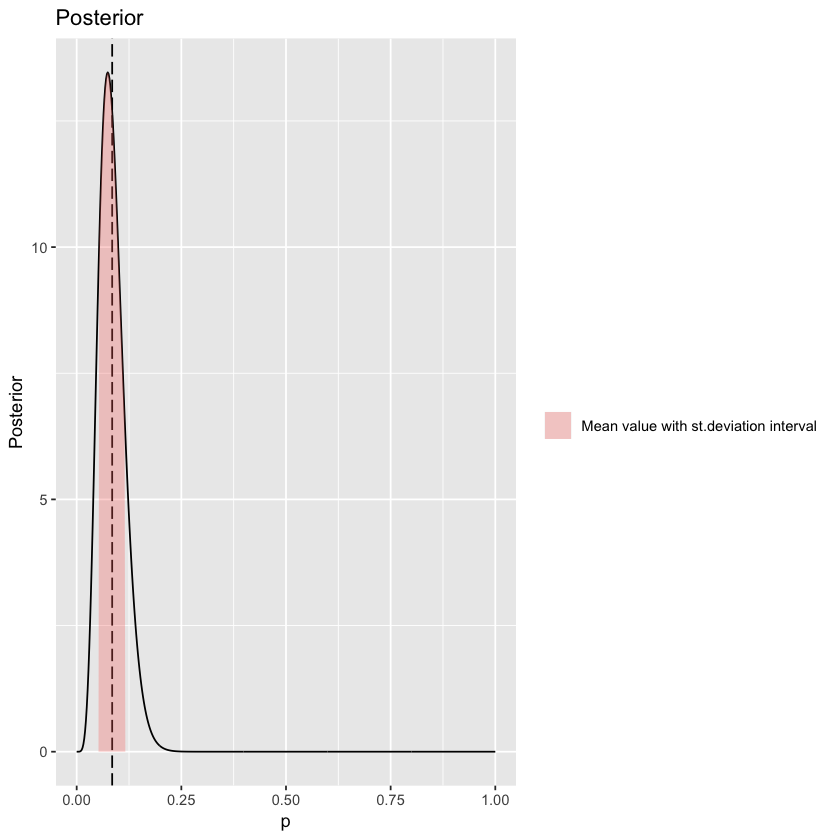

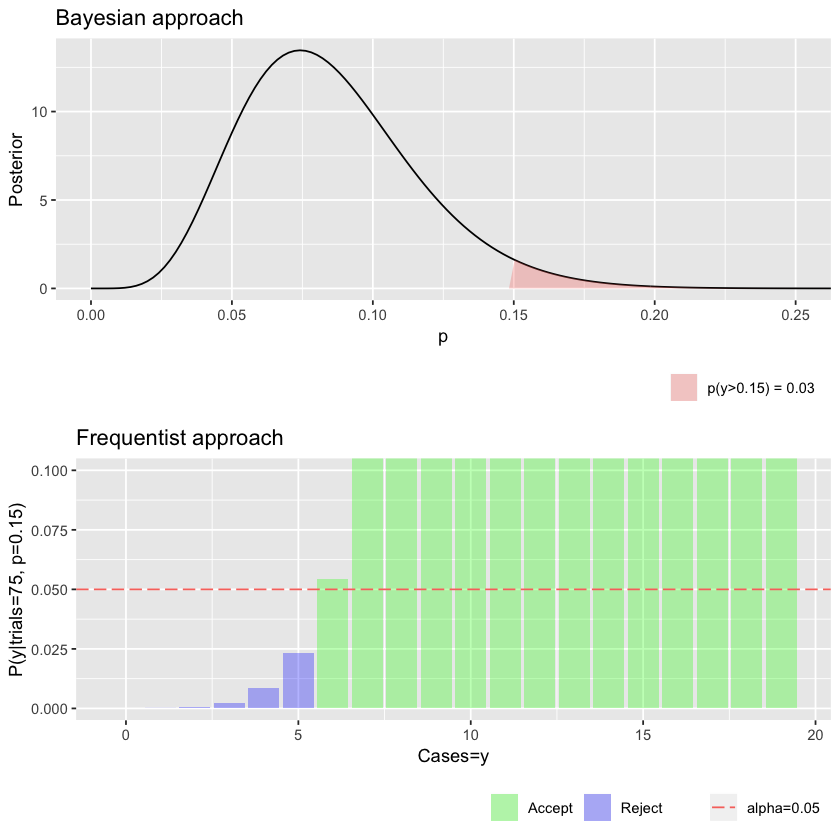

In [13]:
n.trials<-75
cases<-6 
f <- cases/n.trials
mu <- 0.15
sigma <- 0.14
var <- sigma^2

alpha <- (mu*(mu*(1-mu)/var-1))
beta <- (1-mu)*(mu*(1-mu)/var-1)
alpha.s <- cases+alpha
beta.s <- n.trials-cases+beta
p.mean <- alpha.s/(alpha.s+beta.s)
p.var <- alpha.s*beta.s/((alpha.s+beta.s)^2*(alpha.s+beta.s+1))
p.sd <- sqrt(p.var)

p <- seq(0,1,len=500)
likelihood <- dbinom(x=cases, p=p, size=n.trials)
prior_b <-dbeta(x=p, shape1=alpha, shape2=beta)
norm_b<-integrate(dbeta, lower=0, upper=1, shape1=alpha.s, shape2=beta.s)$value
posteriorF_b<-function(p){return(dbeta(x=p, shape1=alpha.s, shape2=beta.s)/norm_b)}
posterior_b <- posteriorF_b(p)

#Plots

ggplot()+
    geom_line(aes(x=p, y=posterior_b))+
    geom_vline(xintercept = p.mean, linetype="longdash", size=0.5)+
    geom_area(aes(x=p, y=ifelse(p>p.mean-p.sd & p< p.mean+p.sd, posterior_b, 0), fill='Mean value with st.deviation interval'), alpha=0.3)+
    ylim(0, max(posterior_b))+
    labs(title='Posterior', y='Posterior', fill='')

P <- integrate(posteriorF_b, lower=0.15, upper=1)$value

plotA <- ggplot()+
    geom_line(aes(x=p, y=posterior_b))+
    geom_area(aes( x = p, y=ifelse(p>0.15, posterior_b, 0), fill=sprintf('p(y>0.15) = %.2f ' , P)), alpha=0.3)+
    coord_cartesian(xlim=c(0,0.25))+
    labs(fill='', colour='', title='Bayesian approach', y='Posterior') +
    theme(legend.position="bottom",legend.justification = c("right", "top"))

trials <- seq(0, n.trials, len=n.trials+1)
alpha <- pbinom(q=6, size=n.trials, prob=0.15)
l.limit <- qbinom(p=0.95, size=n.trials, prob=0.15)

plotB <- ggplot() +
    geom_bar(aes(x=trials[1:20], y=pbinom(q=trials, size=n.trials, prob=0.15)[1:20], , fill=(trials[1:20] <= 5)), stat = "identity")+
    geom_hline(aes(yintercept = 0.05, color='alpha=0.05'), linetype="longdash", size=0.5)+
    scale_fill_manual(values = alpha(c("green", "blue"), .3), labels=c('Accept', 'Reject'))  +
    theme(legend.position="bottom",legend.justification = c("right", "top"))+
    coord_cartesian(ylim=c(0,0.1))+
    labs(title='Frequentist approach', y='P(y|trials=75, p=0.15)', fill='', color='', x='Cases=y')

grid.arrange(plotA, plotB, ncol=1)

# Exercise 2

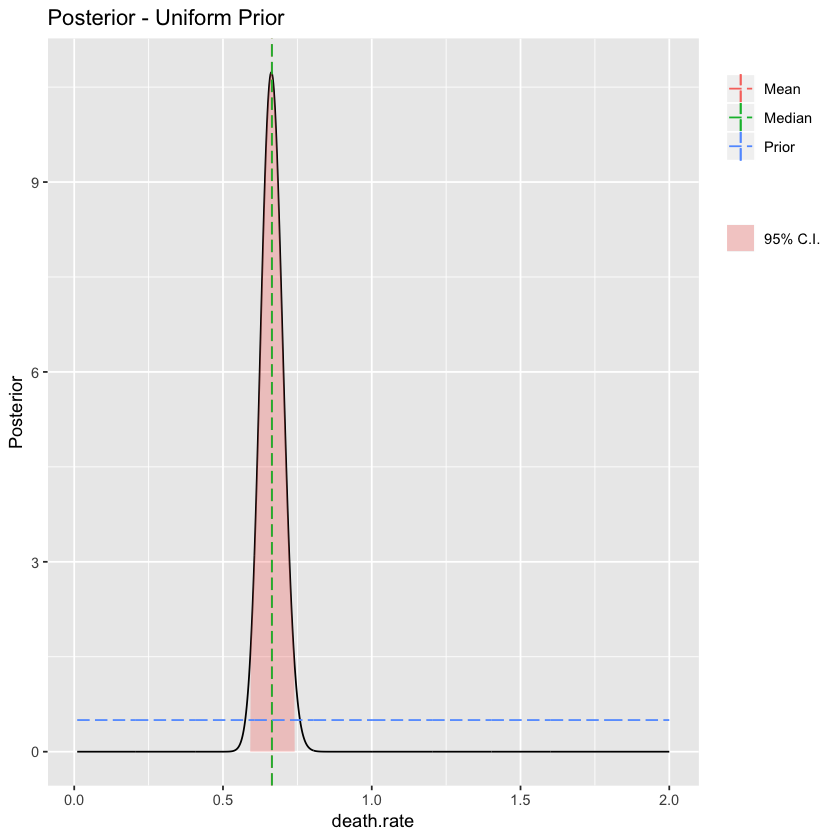

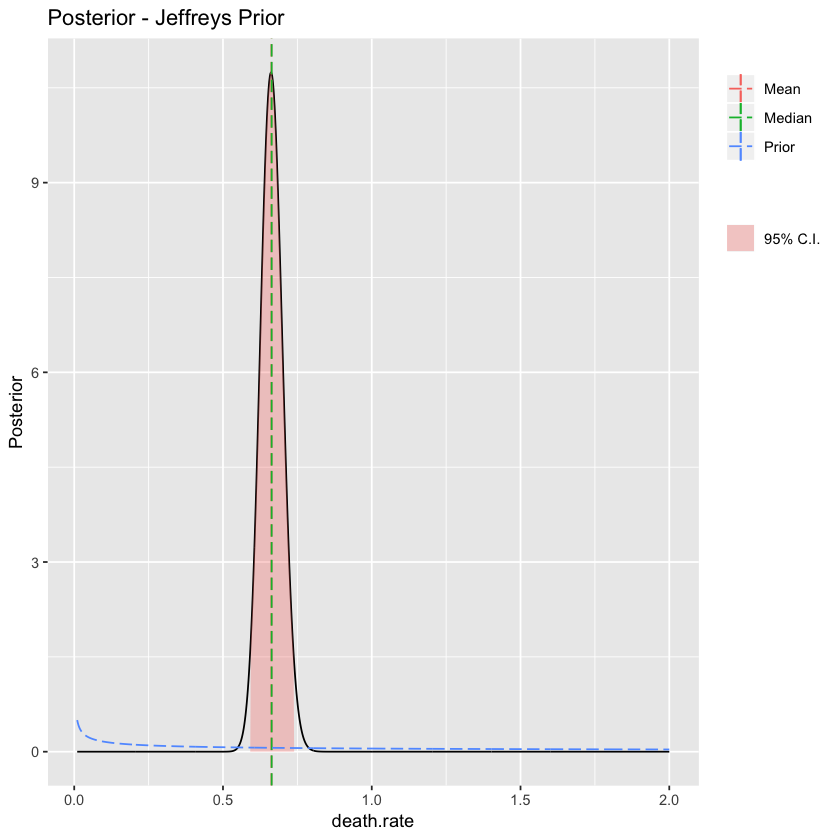

In [14]:
death <- c(0, 1, 2, 3, 4)
n1 <- c(109, 65, 22, 3, 1)
n2 <- c(144, 91, 32, 11, 2)

total <- death*n1+death*n2
sum.obs <- sum(n1)+sum(n2)
alpha.vec <- c(sum(total)+1, sum(total)+1/2)

death.rate <- seq(0.01, 2, len=1000)
priors <- rbind(dunif(death.rate, min=0, max=2), 1/(20*sqrt(death.rate)))
title <-c('Posterior - Uniform Prior', 'Posterior - Jeffreys Prior')

for (i in 1:2) {
    Posterior <- dgamma(x=death.rate, shape=alpha.vec[i], rate=sum.obs)
    min <- qgamma(p=0.025, shape=alpha.vec[i], rate=sum.obs)
    max <- qgamma(p=0.975, shape=alpha.vec[i], rate=sum.obs)

    mean.s <- alpha.vec[i]/sum.obs
    variance.s <- alpha.vec[i]/(sum.obs^2)
    median <-qgamma(p=0.5, shape=alpha.vec[i], rate=sum.obs)

    plot1 <- ggplot()+
        geom_line(aes(x = death.rate, y=Posterior))+
        geom_area(aes(x = death.rate, y=ifelse(death.rate > min & death.rate < max, Posterior, 0), fill='95% C.I.'), alpha=0.3)+
        ylim(0, max(Posterior))+
        geom_vline(aes(xintercept = median, color='Mean'), linetype="longdash", size=0.5)+
        geom_vline(aes(xintercept = mean.s, color='Median'), linetype="longdash", size=0.5)+
        geom_line(aes(x=death.rate, y=priors[i, ], color='Prior'), linetype='longdash', size=0.5)+
        theme(legend.position="right", legend.justification = c("right", "top"))+
        labs(fill='', colour='', title=title[i])
    
    print(plot1)
    map = death.rate[which.max(Posterior)]
}

The $\lambda$ values for the two approaches are: $\lambda = 0.663$ for the Uniform prior and $\lambda = 0.661$ for the Jeffreys prior.

# Exercise 3

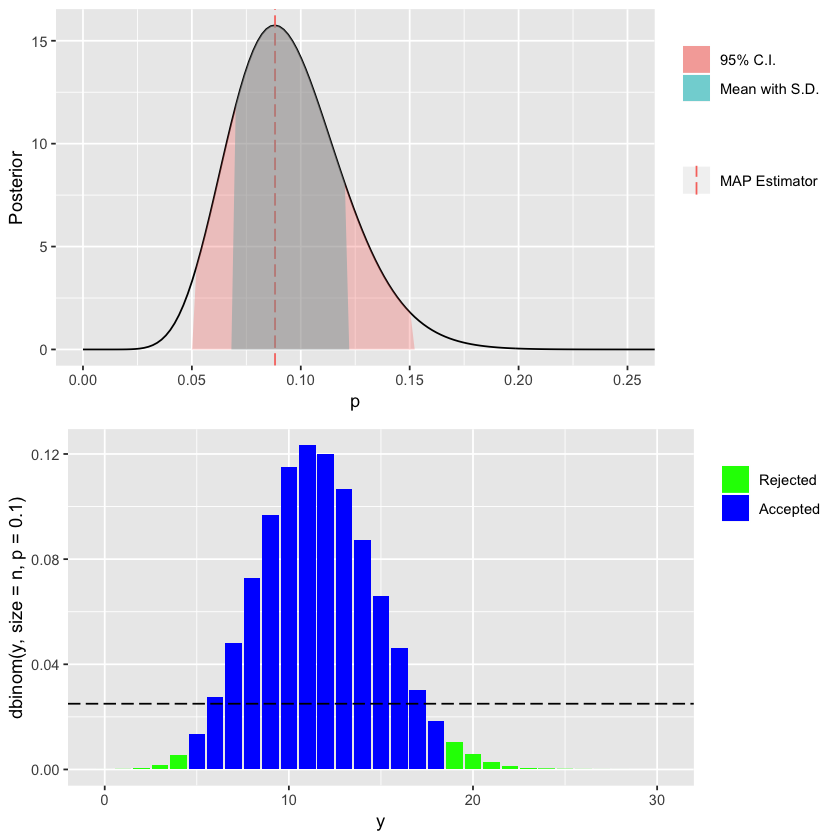

In [15]:
#First set of samples

n <- 116
bact <- 11 
p_frequentist <- 11/116


alpha <- 1
beta <- 10
alpha.s <- bact+alpha
beta.s <- n-bact+beta
var <- (alpha.s*beta.s)/((alpha.s+beta.s)^2*(alpha.s+beta.s+1))
mean <- alpha.s / (alpha.s + beta.s)
sd <- sqrt(var)

p <- seq(0,1,len=500)
likelihood <- dbinom(x=bact, p=p, size=n)
prior <- dbeta(x=p, shape1=alpha, shape2=beta)
Posterior <- dbeta(x=p, shape1=alpha.s, shape2=beta.s)
map <- p[which.max(Posterior)]
lower<-qbeta(p=0.025, shape1=alpha.s, shape2=beta.s)
upper<-qbeta(p=0.975, shape1=alpha.s, shape2=beta.s)

plotA <- ggplot()+
    geom_line(aes(x=p, y=Posterior))+
    geom_vline(aes(xintercept=map, color='MAP Estimator'), linetype="longdash", size=0.5)+
    geom_area(aes(x=p, y=ifelse(p>mean-sd & p<mean+sd, Posterior, 0), fill='Mean with S.D.'), alpha=0.4)+
    geom_area(aes(x=p, y=ifelse(p>lower & p<upper, Posterior, 0), fill='95% C.I.'), alpha=0.3)+
    labs(color='', fill='')+
    theme(legend.position="right", legend.justification = c("right", "top"))+
    coord_cartesian(xlim=c(0,0.25))

y <- seq(0, 30, len=31)

plotB <- ggplot()+
    geom_bar(aes(x=y, y=dbinom(y, size=n, p=0.1), fill=(y>=5 & y<=18)), stat = "identity")+
    geom_hline(aes(yintercept = 0.025), linetype="longdash", size=0.5)+
    labs(fill='')+
    scale_fill_manual(values = c('green', 'blue'), labels=c('Rejected', 'Accepted')) +
    theme(legend.position="right", legend.justification = c("right", "top"))

b1 <-pbinom(q=5,size=n, prob=0.1)+1-pbinom(q=18,size=n, prob=0.1)

grid.arrange(plotA, plotB, ncol=1)

For the first set of samples we can accept the null hypothesis using the bayesian approach, also the frequentist one gives the same answer. We have p=0.1 so it is in the $95\%$ credibility interval.

In [16]:
#Second set of samples

#Binomial test

binom.test(x=bact, n=n, p=0.1)


	Exact binomial test

data:  bact and n
number of successes = 11, number of trials = 116, p-value = 1
alternative hypothesis: true probability of success is not equal to 0.1
95 percent confidence interval:
 0.04829409 0.16333954
sample estimates:
probability of success 
            0.09482759 


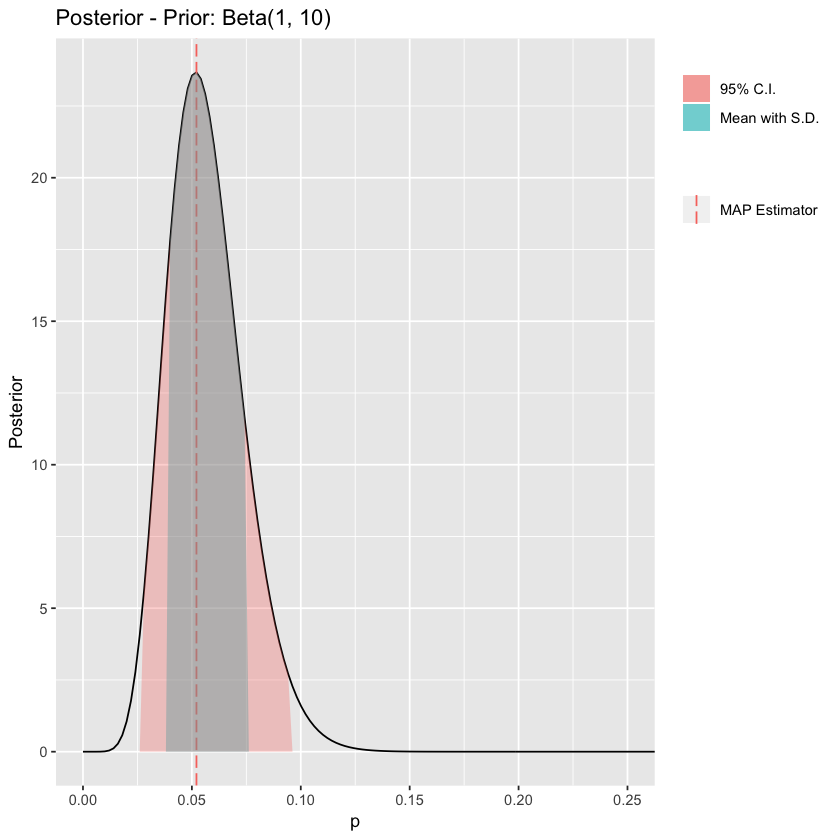

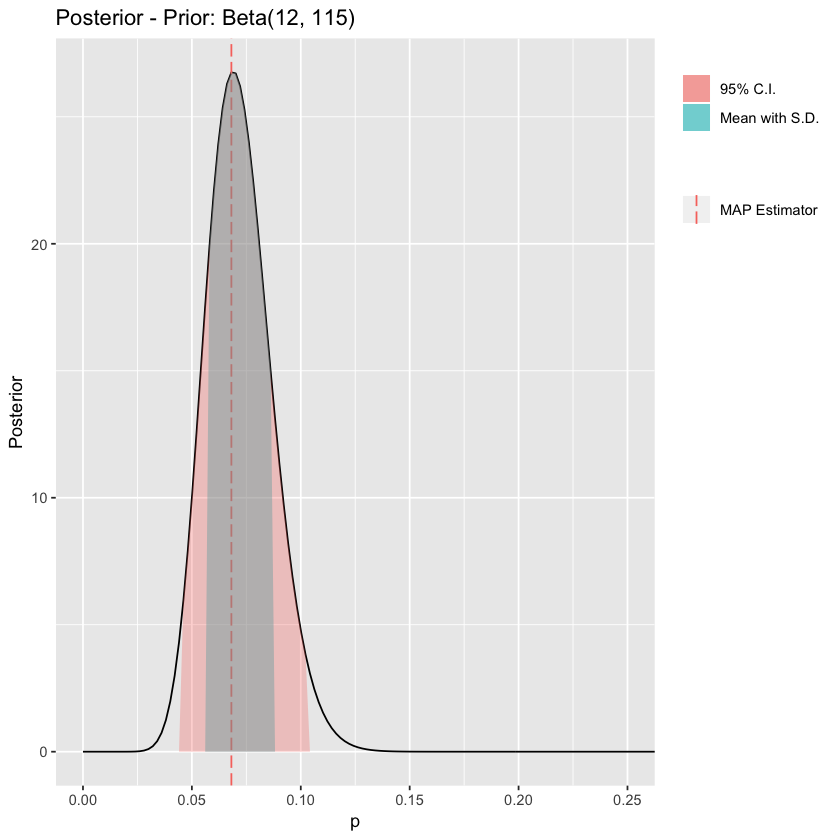

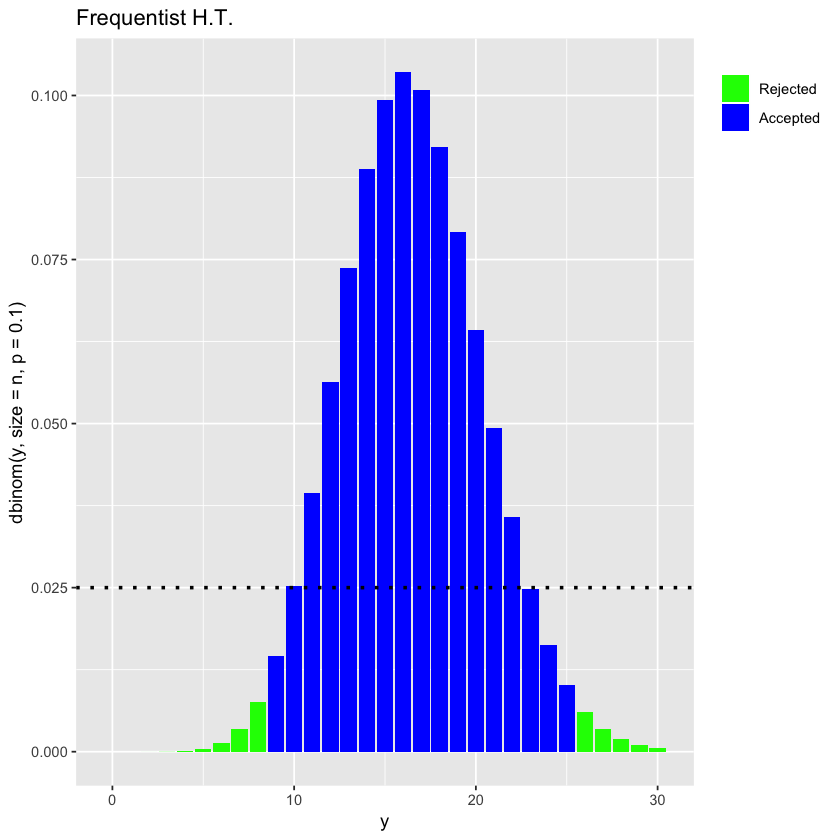

In [17]:
alpha.vec <- c(alpha, alpha+bact)
beta.vec <- c(beta, beta+n-bact)

n <- 165
bact <- 9 
p_frequentist <- 9/165

for (i in 1:2) {
    alpha <- alpha.vec[i]
    beta <- beta.vec[i]
    alpha.s <- bact+alpha
    beta.s <- n-bact+beta
    var <- (alpha.s*beta.s)/((alpha.s+beta.s)^2*(alpha.s+beta.s+1))
    mean <- alpha.s / (alpha.s + beta.s)
    sd <- sqrt(var)

    p <- seq(0,1,len=500)
    likelihood <- dbinom(x=bact, p=p, size=n)
    prior <- dbeta(x=p, shape1=alpha, shape2=beta)
    Posterior <- dbeta(x=p, shape1=alpha.s, shape2=beta.s)
    map <- p[which.max(Posterior)]
    lower<-qbeta(p=0.025, shape1=alpha.s, shape2=beta.s)
    upper<-qbeta(p=0.975, shape1=alpha.s, shape2=beta.s)

    plotC <- ggplot()+
        geom_line(aes(x=p, y=Posterior))+
        geom_vline(aes(xintercept = map, color='MAP Estimator'), linetype="longdash", size=0.5)+
        geom_area(aes( x =p, y=ifelse(p > mean-sd & p < mean+sd, Posterior, 0), fill='Mean with S.D.'), alpha=0.4)+
        geom_area(aes( x =p, y=ifelse(p > lower & p < upper, Posterior, 0), fill='95% C.I.'), alpha=0.3)+
        labs(color='', fill='', title=sprintf('Posterior - Prior: Beta(%.f, %.f)' , alpha, beta))+
        theme(legend.position="right", legend.justification = c("right", "top"))+
        coord_cartesian(xlim=c(0,0.25))

    print(plotC)
}

y <- seq(0, 30, len=31)

plotD <- ggplot()+
    geom_bar(aes(x=y, y=dbinom(y, size=n, p=0.1), fill=(y>=9 & y<=25)), stat = "identity")+
    geom_hline(aes(yintercept = 0.025), linetype="dotted", size=1)+
    labs(fill='', title='Frequentist H.T.')+
    scale_fill_manual(values = c('green', 'blue'), labels=c('Rejected', 'Accepted'))  +
    theme(legend.position="right", legend.justification = c("right", "top"))

plotD

For the second set of samples, for the Beta(1,10) prior we get that p=0.1 is in the rejection region for $\alpha=0.05$, but for the Beta(12,115) prior p=0.1 is in the acceptance region for the same value of $\alpha$. Using the frequentist approach we have that y=11 could be accepted for the same value of $\alpha$.

# Exercise 4

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 75
   Unobserved stochastic nodes: 2
   Total graph size: 81

Initializing model


Iterations = 10001:20000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean      SD  Naive SE Time-series SE
p 0.08497 0.03019 0.0003019      0.0003078
y 0.86090 0.93061 0.0093061      0.0093061

2. Quantiles for each variable:

     2.5%     25%     50%   75%  97.5%
p 0.03585 0.06304 0.08192 0.103 0.1524
y 0.00000 0.00000 1.00000 1.000 3.0000



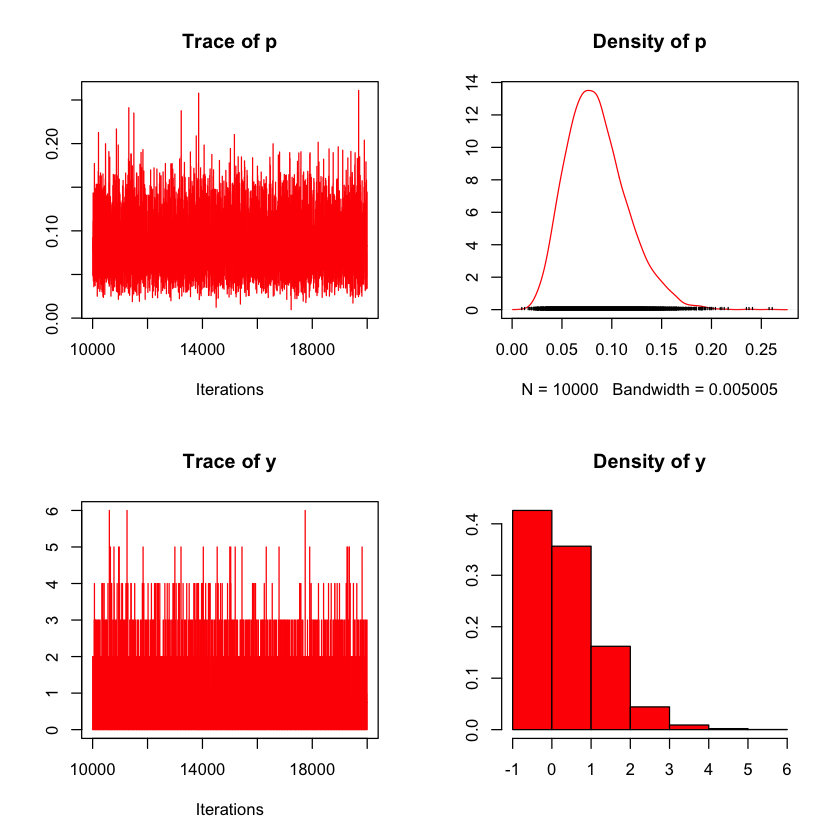

In [18]:
Mean4 <- 0.15
Std4 <- 0.14
Sample <- Mean4*(1-Mean4)/Std4^2
alpha.prior <- Sample*Mean4
beta.prior <- Sample*(1-Mean4)

x <- 6
n <- 75
data_obs <- rep(c(0, 1), c(n-x, x))
data <- NULL
data$X <- data_obs
data$n <- n
data$n_next <- 10
data$alpha <- alpha.prior
data$beta  <- beta.prior

jm <- jags.model(file=paste("Model_Ex4.txt"), data)

# Updating the Markov Chain

update(jm , 10000)
MarkovChain <- coda.samples(jm , c("p", "y"), n.iter=10000)

#Summary

print(summary(MarkovChain))

#Plot of the infered distribution

plot(MarkovChain , col="red")

# Exercise 5

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 204

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD Naive SE Time-series SE
lambda 0.6144 0.0561 0.000561      0.0007328
y      0.6246 0.7980 0.007980      0.0079796

2. Quantiles for each variable:

         2.5%    25%    50%    75% 97.5%
lambda 0.5089 0.5759 0.6127 0.6518 0.728
y      0.0000 0.0000 0.0000 1.0000 3.000

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 2
   Total graph size: 284

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per ch

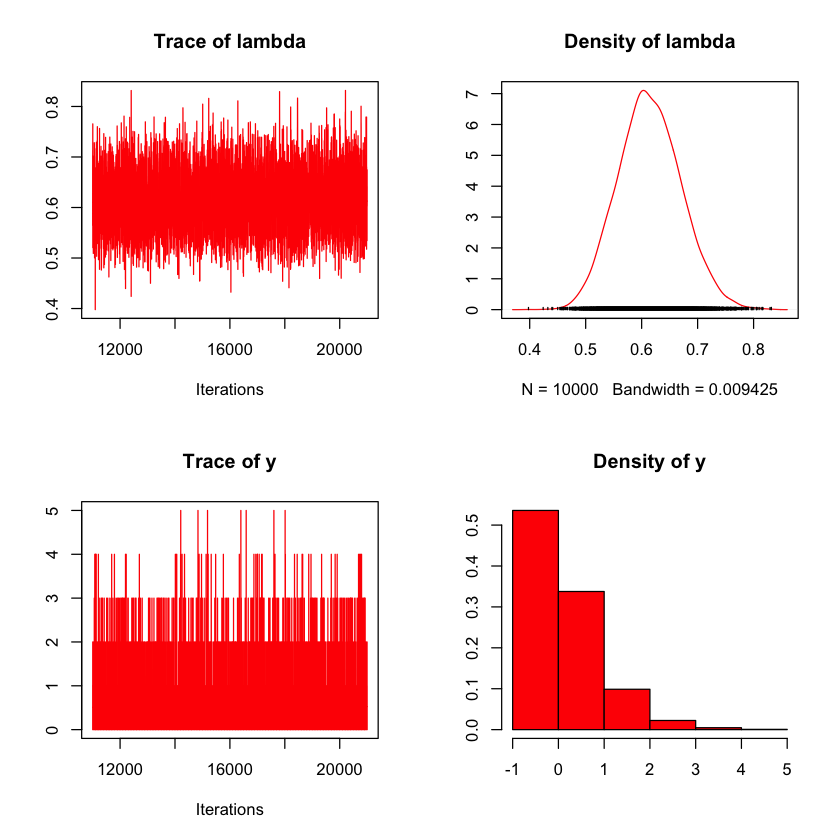

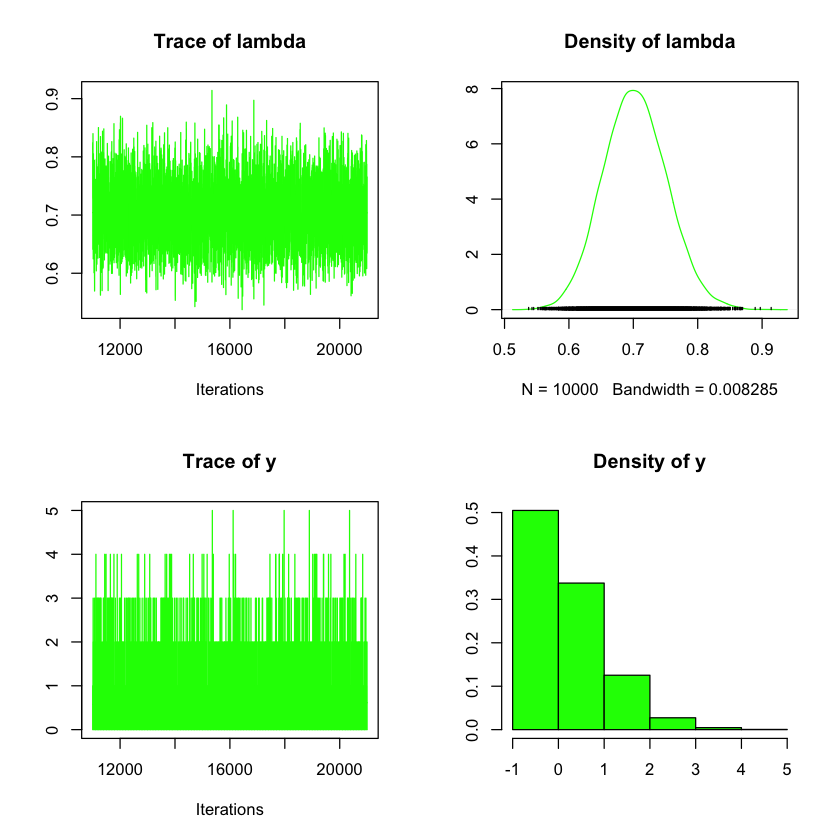

In [19]:
y <- c(0, 1, 2, 3, 4)
n1 <- c(109, 65, 22, 3, 1)
n2 <- c(144, 91, 32, 11, 2)
n <- length(n1)

alpha1 <- sum(n1*y)+1
lambda1 <- sum(n1)

alpha2 <- sum(n2*y)+1
lambda2 <- sum(n2)

#Uniform Prior

data_obs1 <- rep(y, n1)
data1 <- NULL
data1$X <- data_obs1
data1$min.prior <- 0
data1$max.prior <- 10
data_obs2 <- rep(y, n2)
data2 <- NULL
data2$X <- data_obs2
data2$min.prior <- 0
data2$max.prior <- 10

jm1 <- jags.model(file=paste("Model_Ex5_Uniform.txt"), data1)

update(jm1 , 10000)
MarkovChain1 <- coda.samples(jm1 , c("lambda", "y"), n.iter=10000)
print(summary(MarkovChain1))

plot(MarkovChain1 , col="red")

jm2 <- jags.model(file=paste("Model_Ex5_Uniform.txt"), data2)

update(jm2 , 10000)
MarkovChain2 <- coda.samples(jm2 , c("lambda", "y"), n.iter=10000)
print(summary(MarkovChain2))

plot(MarkovChain2 , col="green")

Warning message in jags.model(file = paste("Model_Ex5_Jeffrey.txt"), data1):
“Unused variable "min.prior" in data”Warning message in jags.model(file = paste("Model_Ex5_Jeffrey.txt"), data1):
“Unused variable "max.prior" in data”

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 205

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
lambda 0.6167 0.05561 0.0005561      0.0007135
y      0.6235 0.79512 0.0079512      0.0079512

2. Quantiles for each variable:

         2.5%    25%   50%   75%  97.5%
lambda 0.5124 0.5782 0.615 0.653 0.7293
y      0.0000 0.0000 0.000 1.000 3.0000



Warning message in jags.model(file = paste("Model_Ex5_Jeffrey.txt"), data2):
“Unused variable "min.prior" in data”Warning message in jags.model(file = paste("Model_Ex5_Jeffrey.txt"), data2):
“Unused variable "max.prior" in data”

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 2
   Total graph size: 285

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
lambda 0.7068 0.05056 0.0005056      0.0006776
y      0.7108 0.83560 0.0083560      0.0083560

2. Quantiles for each variable:

         2.5%    25%    50%    75% 97.5%
lambda 0.6106 0.6719 0.7057 0.7405 0.808
y      0.0000 0.0000 1.0000 1.0000 3.000



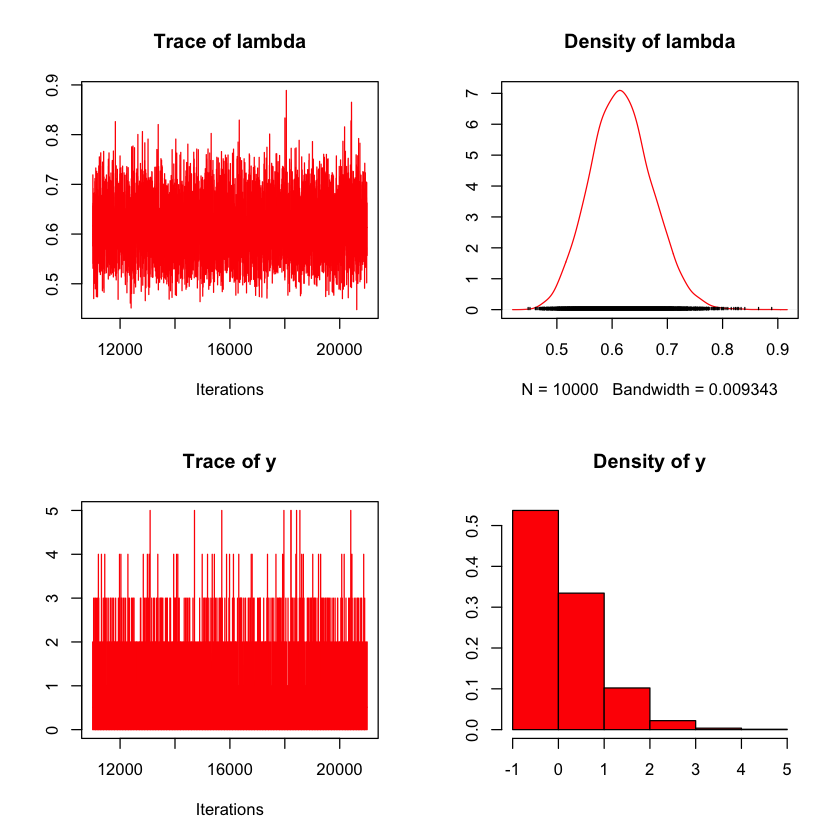

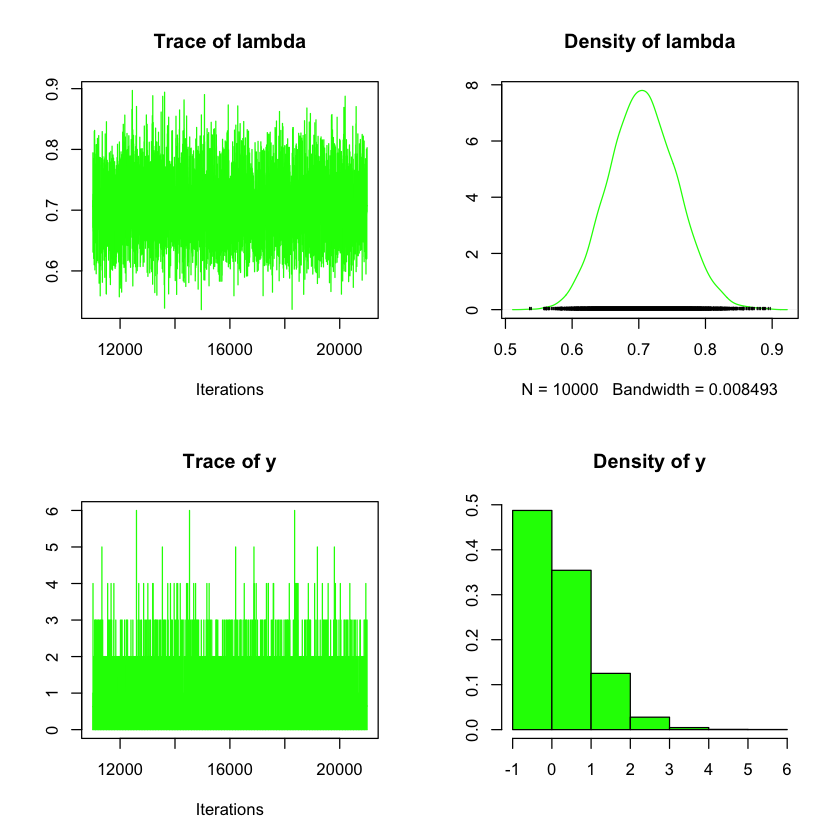

In [20]:
# Jeffrey's Prior

data_obs1 <- rep(y, n1)
data1 <- NULL
data1$X <- data_obs1
data1$min.prior <- 0
data1$max.prior <- 10
data_obs2 <- rep(y, n2)
data2 <- NULL
data2$X <- data_obs2
data2$min.prior <- 0
data2$max.prior <- 10

jm1 <- jags.model(file=paste("Model_Ex5_Jeffrey.txt"), data1)

update(jm1 , 10000)
MarkovChain1 <- coda.samples(jm1 , c("lambda", "y"), n.iter=10000)
print(summary(MarkovChain1))

plot(MarkovChain1 , col="red")

jm2 <- jags.model(file=paste("Model_Ex5_Jeffrey.txt"), data2)

update(jm2 , 10000)
MarkovChain2 <- coda.samples(jm2 , c("lambda", "y"), n.iter=10000)
print(summary(MarkovChain2))

plot(MarkovChain2 , col="green")

# Exercise 6

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 75
   Unobserved stochastic nodes: 2
   Total graph size: 81

Initializing model


Iterations = 10001:20000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

    Mean     SD Naive SE Time-series SE
p 0.1397 0.0369 0.000369      0.0003387
y 1.3947 1.1495 0.011495      0.0114954

2. Quantiles for each variable:

     2.5%    25%    50%    75%  97.5%
p 0.07487 0.1133 0.1372 0.1629 0.2196
y 0.00000 1.0000 1.0000 2.0000 4.0000



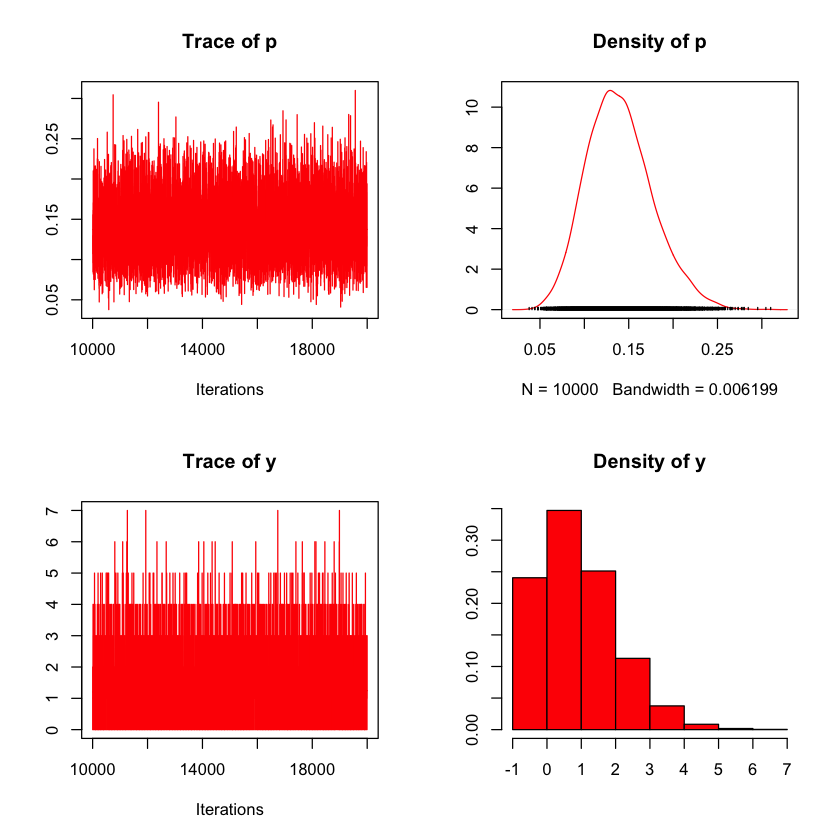

In [21]:
alpha.prior <- 1
beta.prior <- 10
x <- 11
n <- 75

data_obs <- rep(c(0, 1), c(n-x, x))
data <- NULL
data$X <- data_obs
data$n <- n
data$n_next <- 10
data$alpha <- alpha.prior
data$beta  <- beta.prior

jm <- jags.model(file=paste("Model_Ex6.txt"), data)

update(jm , 10000)
MarkovChain <- coda.samples(jm , c("p", "y"), n.iter=10000)
print(summary(MarkovChain))

plot(MarkovChain , col="red")

In [22]:
# Distribution Values

ValuesEx6<-summary(MarkovChain)
StatValueEx6 <- ValuesEx6$statistics
cat(paste('Mean: ', round(StatValueEx6[1,'Mean'], 3)))
cat(paste('\nMedian: ', round(ValuesEx6$quantiles[[1,'50%']], 3)))
cat(paste('\nStandard Deviation:', round(StatValueEx6[[1,'SD']], 3)))
cat(paste('\nThe interval of values for p corresponding to a 95% CL is: ', '[', round(ValuesEx6$quantiles[[1,'2.5%']], 3), ';', round(ValuesEx6$quantiles[[1,'97.5%']], 3), ']'))

Mean:  0.14
Median:  0.137
Standard Deviation: 0.037
The interval of values for p corresponding to a 95% CL is:  [ 0.075 ; 0.22 ]